# 01 · EDA & Sentiment for H5N1 Digital Epidemiology

This notebook performs exploratory data analysis and sentiment/tone extraction on H5N1-related posts.
It is keyed to the CDC announcement on 2024-04-04 and prepares daily aggregates & plots for pre/post comparisons.

What you'll get:
- Column inference (time, text, user)
- Cleaning & structure features (hashtags, mentions, urls, lengths, retweet flag)
- Sentiment (VADER with a lexicon fallback)
- Tone features (fear, uncertainty, urgency, safety/trust)
- Daily aggregates + charts (with a vertical line at 2024-04-04)
- Pre vs post summary stats

In [6]:
!pip install vaderSentiment

ERROR: Could not find a version that satisfies the requirement vaderSentiment (from versions: none)
ERROR: No matching distribution found for vaderSentiment


In [3]:
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters (override with env var H5N1_CSV_PATH if desired)
DATA_PATH = "data/H5N1_ -is_retweet since_2022-06-01 until_2025-01-01 lang_en.csv"

ANNOUNCE_DATE = pd.Timestamp("2024-04-04")

print("DATA_PATH:", DATA_PATH)
print("ANNOUNCE_DATE:", ANNOUNCE_DATE)

df = pd.read_csv(DATA_PATH, low_memory=False)
print("Rows:", len(df))
df.head(3)

DATA_PATH: data/H5N1_ -is_retweet since_2022-06-01 until_2025-01-01 lang_en.csv
ANNOUNCE_DATE: 2024-04-04 00:00:00
Rows: 183211


,_id,userId,userName,alias,profilePicture,userCreatedAt,bio,followers,following,lists,...,firstLink,images,impressions,isImage,firstImage,location,url,noteTweetText,retweetedUserId,reportName
0,1697387307949797665,1197585796775079936,Ishi Nobu い忍ふ,ishinobu_actual,https://pbs.twimg.com/profile_images/124190203...,2019-11-21T18:41:32.000Z,An independent polymath scholar & guru. My boo...,1058,121,23,...,https://www.nytimes.com/2023/08/31/opinion/bir...,[],120.0,False,NaN,Oregon (US),https://x.com/user/status/1697387307949797665,NaN,NaN,NaN
1,1697385383158260177,27540099,Eric W. Sanderson,ewsanderson,https://pbs.twimg.com/profile_images/128666077...,2009-03-30T00:18:46.000Z,VP Urban conservation @NYBG formerly @TheWCS. ...,3578,3313,164,...,https://nyti.ms/47XasiO,[],52.0,False,NaN,Bronx NY,https://x.com/user/status/1697385383158260177,NaN,NaN,NaN
2,1697384658231841182,796408675,Mary,awoofoflove,https://pbs.twimg.com/profile_images/256619801...,2012-09-01T16:21:39.000Z,The love of our dogs,389,874,4,...,http://dlvr.it/SvSQk3,[],98.0,False,NaN,NaN,https://x.com/user/status/1697384658231841182,NaN,NaN,NaN


## Column inference, normalization, and cleaning

In [4]:
# Heuristic column detection
cand_text = [c for c in df.columns if c.lower() in {"text","content","tweet_text","full_text","body"} or "text" in c.lower() or "content" in c.lower()]
cand_time = [c for c in df.columns if any(k in c.lower() for k in ["created","timestamp","time","date"])]
cand_user = [c for c in df.columns if any(k in c.lower() for k in ["user","author","screen_name","username"])]
cand_lang = [c for c in df.columns if "lang" in c.lower()]
cand_rt   = [c for c in df.columns if "retweet" in c.lower() or "is_rt" in c.lower() or "is_retweet" in c.lower()]

text_col = cand_text[0] if cand_text else df.columns[0]
time_col = cand_time[0] if cand_time else df.columns[1]
user_col = cand_user[0] if cand_user else None
lang_col = cand_lang[0] if cand_lang else None
rt_col   = cand_rt[0] if cand_rt else None

print("text_col:", text_col)
print("time_col:", time_col)
print("user_col:", user_col)
print("lang_col:", lang_col)
print("rt_col:", rt_col)

# Normalize time (tz-naive) and basic filters
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", utc=True).dt.tz_convert(None)
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

if lang_col:
    df = df[df[lang_col].astype(str).str.lower().isin(["en","eng","english"]) | df[lang_col].isna()]

df[text_col] = df[text_col].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()

df["date"] = df[time_col].dt.date
df["pre_post"] = np.where(df[time_col] < ANNOUNCE_DATE, "pre", "post")

# Structure features
df["hashtag_count"] = df[text_col].str.count(r"#\w+")
df["mention_count"] = df[text_col].str.count(r"@\w+")
df["url_count"]     = df[text_col].str.count(r"http[s]?://")
df["char_len"]      = df[text_col].str.len()
df["token_len"]     = df[text_col].str.split().str.len()

# Retweet flag
if rt_col:
    df["is_retweet"] = df[rt_col].astype(str).str.lower().isin(["true","1","yes","y","t"])
else:
    df["is_retweet"] = df[text_col].str.startswith("RT @")

print("Time range:", df[time_col].min(), "→", df[time_col].max())
print("Pre/Post counts:\n", df["pre_post"].value_counts())
df[[time_col, text_col, "pre_post", "hashtag_count", "mention_count", "url_count"]].head(5)

text_col: text
time_col: userCreatedAt
user_col: userId
lang_col: lang
rt_col: totalRetweets
Time range: 2006-07-13 04:45:19 → 2024-12-31 10:28:47
Pre/Post counts:
 pre_post
pre     178071
post      4879
Name: count, dtype: int64


,userCreatedAt,text,pre_post,hashtag_count,mention_count,url_count
0,2006-07-13 04:45:19,@AcaOtaku A mask as main push seems too covid ...,pre,0,1,0
1,2006-07-13 04:45:19,@EricTopol @Nature Yikes. Every couple of days...,pre,0,2,0
2,2006-07-27 03:38:25,@Plinz h5n1 in 38% of milk samples tested http...,pre,0,1,1
3,2006-08-02 12:42:25,As bird flu fears rise the world is negotiatin...,pre,0,0,1
4,2006-08-05 18:59:05,Dr. Bonnie Henry just said that we catch H5N1 ...,pre,0,0,1


## Sentiment (VADER with fallback)

In [5]:
def compute_vader(texts: pd.Series):
    try:
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        analyzer = SentimentIntensityAnalyzer()
        scores = texts.apply(lambda t: analyzer.polarity_scores(str(t)))
        out = pd.DataFrame(scores.tolist(), index=texts.index)
        out = out.rename(columns={"compound":"sent_compound","pos":"sent_pos","neu":"sent_neu","neg":"sent_neg"})
        return out
    except Exception as e:
        print("VADER not available; using fallback lexicon:", str(e))
        return None

v = compute_vader(df[text_col])

if v is None:
    POS = {"good","great","excellent","helpful","effective","safe","recover","recovering","improve","progress","control","contained","decline","decrease","drop","reduce","resilient"}
    NEG = {"bad","terrible","awful","danger","dangerous","risk","panic","outbreak","spread","infected","infection","deadly","fatal","fear","worry","worried","concern","urgent","emergency","alert","alarm","anxious","unsafe"}
    def simple_scores(s):
        toks = str(s).lower().split()
        pos = sum(t in POS for t in toks)
        neg = sum(t in NEG for t in toks)
        tot = pos + neg
        comp = (pos - neg)/tot if tot>0 else 0.0
        return pd.Series({"sent_pos": pos, "sent_neg": neg, "sent_neu": max(0, len(toks)-tot), "sent_compound": comp})
    v = df[text_col].apply(simple_scores)

df = pd.concat([df, v], axis=1)
df[["sent_compound","sent_pos","sent_neu","sent_neg"]].describe()

VADER not available; using fallback lexicon: No module named 'vaderSentiment'


,sent_compound,sent_pos,sent_neu,sent_neg
count,182950.000000,182950.000000,182950.000000,182950.000000
mean,-0.183560,0.063001,28.781476,0.297420
std,0.486498,0.260509,13.256242,0.584765
min,-1.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,17.000000,0.000000
50%,0.000000,0.000000,29.000000,0.000000
75%,0.000000,0.000000,40.000000,0.000000
max,1.000000,4.000000,101.000000,6.000000


## Tone features

In [7]:
FEAR = {"fear","scared","afraid","panic","terrified","anxious","fright","hysteria"}
UNCERTAINTY = {"uncertain","uncertainty","unknown","unconfirmed","maybe","rumor","unclear","speculation","likely","possible","might"}
URGENCY = {"urgent","alert","emergency","warning","breaking","act now","immediately"}
SAFETY_TRUST = {"safe","safety","effective","guidance","cdc","who","public health","protocol","mask","vaccine","vaccination","prevent","prevention","mitigate","protection","trust"}

def count_terms(s, lex):
    t = str(s).lower()
    return sum(1 for w in lex if w in t)

df["tone_fear"]         = df[text_col].apply(lambda s: count_terms(s, FEAR))
df["tone_uncertainty"]  = df[text_col].apply(lambda s: count_terms(s, UNCERTAINTY))
df["tone_urgency"]      = df[text_col].apply(lambda s: count_terms(s, URGENCY))
df["tone_safety_trust"] = df[text_col].apply(lambda s: count_terms(s, SAFETY_TRUST))

df[["tone_fear","tone_uncertainty","tone_urgency","tone_safety_trust"]].describe()

,tone_fear,tone_uncertainty,tone_urgency,tone_safety_trust
count,182950.000000,182950.000000,182950.000000,182950.000000
mean,0.023990,0.066439,0.043553,0.354201
std,0.157177,0.264296,0.215839,0.647137
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000
max,3.000000,4.000000,3.000000,7.000000


## Daily aggregates & charts

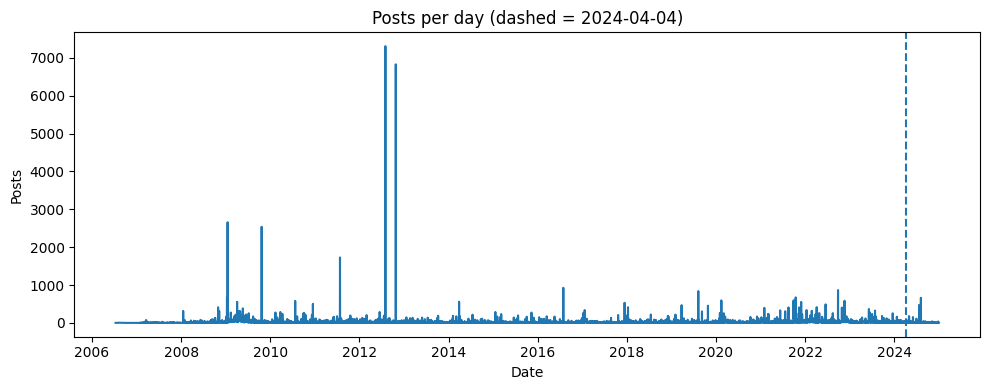

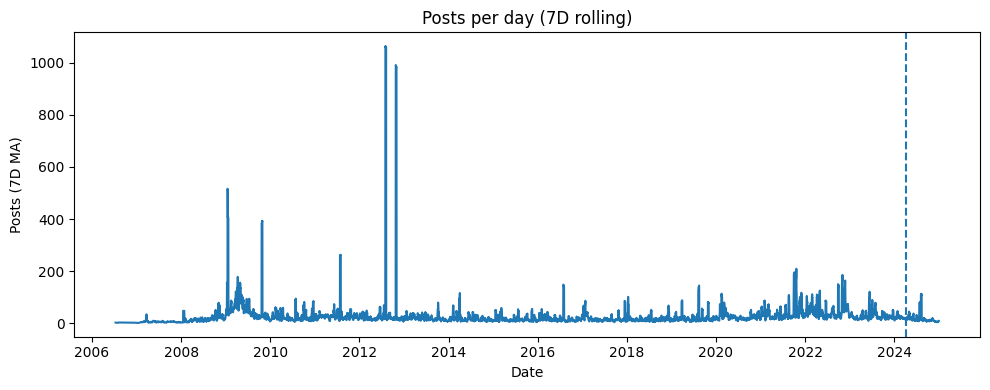

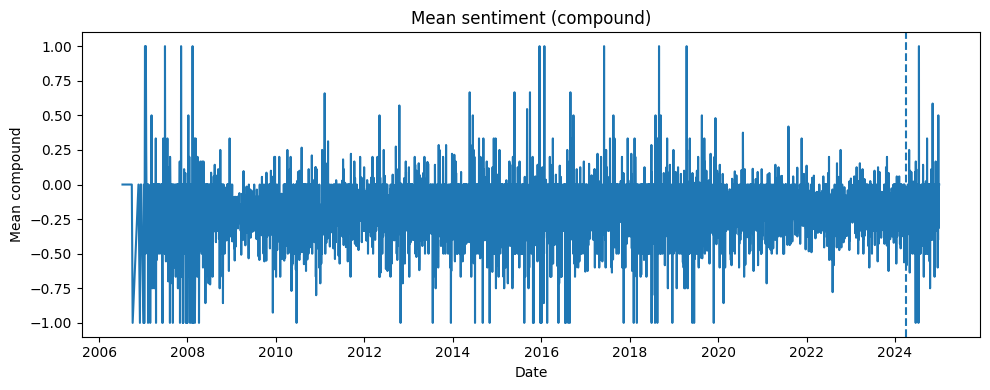

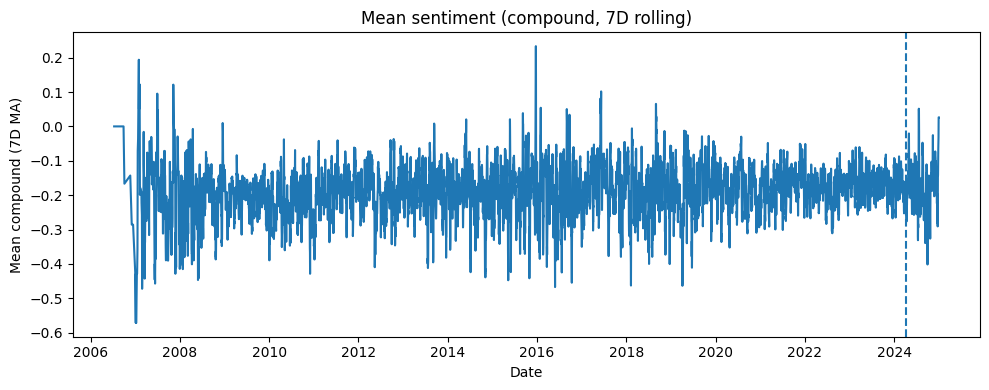

In [8]:
daily = (
    df.groupby("date", dropna=True)
      .agg(
          posts=("date","size"),
          mean_compound=("sent_compound","mean"),
          fear=("tone_fear","sum"),
          uncertainty=("tone_uncertainty","sum"),
          urgency=("tone_urgency","sum"),
          safety_trust=("tone_safety_trust","sum")
      )
      .reset_index()
)

daily["date"] = pd.to_datetime(daily["date"])
daily = daily.sort_values("date")
daily["posts_7d"]    = daily["posts"].rolling(7, min_periods=1).mean()
daily["compound_7d"] = daily["mean_compound"].rolling(7, min_periods=1).mean()

import matplotlib.pyplot as plt
announce_ts = pd.to_datetime(ANNOUNCE_DATE)

plt.figure(figsize=(10,4))
plt.plot(daily["date"], daily["posts"])
plt.axvline(announce_ts, linestyle="--")
plt.title("Posts per day (dashed = 2024-04-04)")
plt.xlabel("Date"); plt.ylabel("Posts")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(daily["date"], daily["posts_7d"])
plt.axvline(announce_ts, linestyle="--")
plt.title("Posts per day (7D rolling)")
plt.xlabel("Date"); plt.ylabel("Posts (7D MA)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(daily["date"], daily["mean_compound"])
plt.axvline(announce_ts, linestyle="--")
plt.title("Mean sentiment (compound)")
plt.xlabel("Date"); plt.ylabel("Mean compound")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(daily["date"], daily["compound_7d"])
plt.axvline(announce_ts, linestyle="--")
plt.title("Mean sentiment (compound, 7D rolling)")
plt.xlabel("Date"); plt.ylabel("Mean compound (7D MA)")
plt.tight_layout(); plt.show()

## Save optional CSVs

In [9]:
OUT_DIR = "data/processed"
os.makedirs(OUT_DIR, exist_ok=True)
daily.to_csv(os.path.join(OUT_DIR, "daily_aggregates.csv"), index=False)
print("Saved:", os.path.join(OUT_DIR, "daily_aggregates.csv"))

Saved: data/processed/daily_aggregates.csv
